# Kickstarter Data Analysis
## Athly Sabish
## Max Beihoff
### 17 October, 2019

## Introduction
For this project we are looking at a data set of 300,000+ Kickstarter projects. We would like to find out if there are any variables that will help predict if the project will be successful or not.

## Hypothesis
We hypothesize that the `goal` and `main category` will be the best predictors in determining if a project will be successful or not.

## Data Set
* The data set was scraped from Kickstarter

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date as date

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

%matplotlib inline

c:\python37\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
raw_data = pd.read_csv("./kickstarter-projects/ks-projects-2018.csv")

In [3]:
raw_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
raw_data.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

* We drop the columns that are duplicates or uneccessary to our analysis

In [5]:
raw_data = raw_data.drop(['goal','pledged','usd pledged','ID','name','category'],axis=1)

### Main Category types

In [6]:
pd.value_counts(raw_data["main_category"].values)

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
dtype: int64

### Currency types

In [7]:
pd.value_counts(raw_data["currency"].values)

USD    295365
GBP     34132
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
dtype: int64

In [8]:
pd.value_counts(raw_data["state"].values)

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
dtype: int64

In [9]:
pd.value_counts(raw_data["country"].values)

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
dtype: int64

In [10]:
raw_data["main_category"] = raw_data["main_category"].astype("category")
raw_data["main_category"].head()

0      Publishing
1    Film & Video
2    Film & Video
3           Music
4    Film & Video
Name: main_category, dtype: category
Categories (15, object): [Art, Comics, Crafts, Dance, ..., Photography, Publishing, Technology, Theater]

In [11]:
raw_data["currency"] = raw_data["currency"].astype("category").head()
raw_data["currency"].head()

0    GBP
1    USD
2    USD
3    USD
4    USD
Name: currency, dtype: category
Categories (14, object): [AUD, CAD, CHF, DKK, ..., NZD, SEK, SGD, USD]

In [12]:
#raw_data["state"] = raw_data["state"].astype("category").head()
#raw_data["state"].head()

In [13]:
raw_data["country"] = raw_data["country"].astype("category").head()
raw_data["country"].head()

0    GB
1    US
2    US
3    US
4    US
Name: country, dtype: category
Categories (23, object): [AT, AU, BE, CA, ..., NZ, SE, SG, US]

Convert dates in launched and deadline categories to datetime datatypes.

In [14]:
type(raw_data["deadline"][0])

str

In [15]:
raw_data["deadline"].head()

0    2015-10-09
1    2017-11-01
2    2013-02-26
3    2012-04-16
4    2015-08-29
Name: deadline, dtype: object

In [16]:
raw_data["launched"].head()

0    2015-08-11 12:12:28
1    2017-09-02 04:43:57
2    2013-01-12 00:20:50
3    2012-03-17 03:24:11
4    2015-07-04 08:35:03
Name: launched, dtype: object

In [17]:
date_format ="%Y-%m-%d"
dt.datetime.strptime(raw_data["deadline"][0], date_format)

datetime.datetime(2015, 10, 9, 0, 0)

In [18]:
converted_deadlines = raw_data["deadline"].map(lambda s: dt.datetime.strptime(s, date_format))
converted_deadlines.head()

0   2015-10-09
1   2017-11-01
2   2013-02-26
3   2012-04-16
4   2015-08-29
Name: deadline, dtype: datetime64[ns]

In [19]:
date_format ="%Y-%m-%d %H:%M:%S"
dt.datetime.strptime(raw_data["launched"][0], date_format)

datetime.datetime(2015, 8, 11, 12, 12, 28)

In [20]:
converted_launches = raw_data["launched"].map(lambda s: dt.datetime.strptime(s, date_format))
converted_launches.head()

0   2015-08-11 12:12:28
1   2017-09-02 04:43:57
2   2013-01-12 00:20:50
3   2012-03-17 03:24:11
4   2015-07-04 08:35:03
Name: launched, dtype: datetime64[ns]

In [21]:
dataDF = raw_data[raw_data["state"].isin(["successful", "failed"])]
dataDF["state"].value_counts

<bound method IndexOpsMixin.value_counts of 0             failed
1             failed
2             failed
3             failed
5         successful
             ...    
378654        failed
378657        failed
378658        failed
378659        failed
378660        failed
Name: state, Length: 331675, dtype: object>

In [22]:
dataDF["state"] = dataDF["state"].astype("category")
dataDF["state"].value_counts

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<bound method IndexOpsMixin.value_counts of 0             failed
1             failed
2             failed
3             failed
5         successful
             ...    
378654        failed
378657        failed
378658        failed
378659        failed
378660        failed
Name: state, Length: 331675, dtype: category
Categories (2, object): [failed, successful]>

## Analyze the data and variable relationships

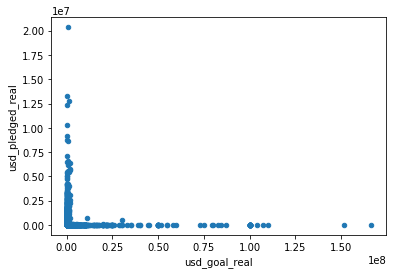

In [23]:
dataDF.plot.scatter(x="usd_goal_real",y="usd_pledged_real")

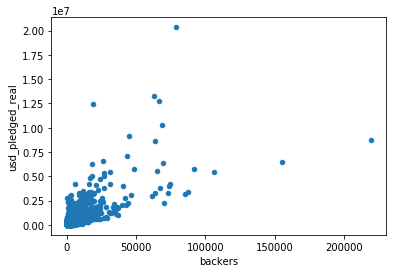

In [24]:
dataDF.plot.scatter(x="backers",y="usd_pledged_real")

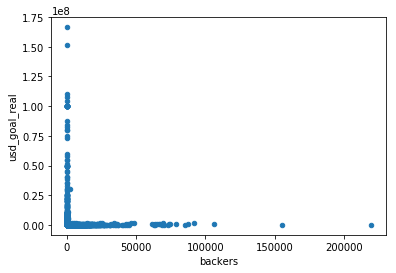

In [25]:
dataDF.plot.scatter(x="backers", y="usd_goal_real")

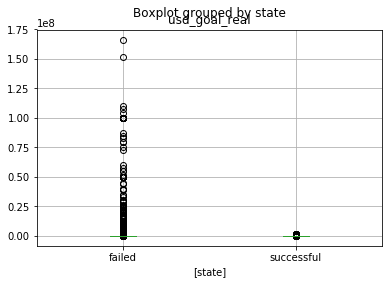

In [26]:
dataDF[["state","usd_goal_real"]].boxplot(by="state")

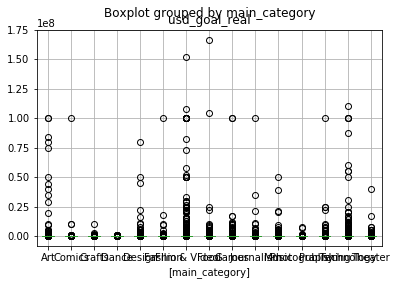

In [27]:
dataDF[["main_category","usd_goal_real"]].boxplot(by="main_category")

We need to count the number of successful projects and find the percentage of all projects that are successful. Then we can find which variales correlate to a high success rate.

In [28]:
def count_success(entries):
    #print(entries)
    successful = 0
    for entry in entries:
        if entry == "successful":
            successful = successful+1
            
    return successful/len(entries)

In [29]:
grouped = dataDF[["main_category", "state"]].groupby(["main_category"], as_index=False, sort=False)
grouped = grouped.aggregate(count_success)
grouped = grouped.rename(columns={"state" : "percent_successful"})
grouped

,main_category,percent_successful
0,Publishing,0.347017
1,Film & Video,0.417906
2,Music,0.526606
3,Food,0.275914
4,Crafts,0.270530
5,Games,0.438905
6,Design,0.415944
7,Comics,0.591415
8,Fashion,0.282832
9,Theater,0.637961


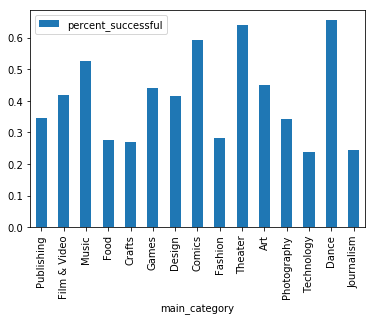

In [30]:
grouped.plot.bar(x="main_category", y="percent_successful")

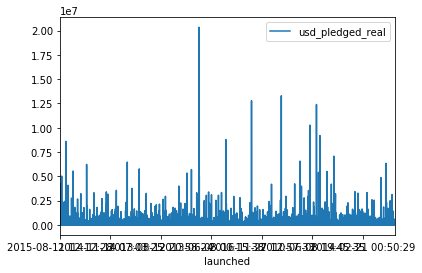

In [31]:
dataDF.plot.line(x="launched", y="usd_pledged_real")

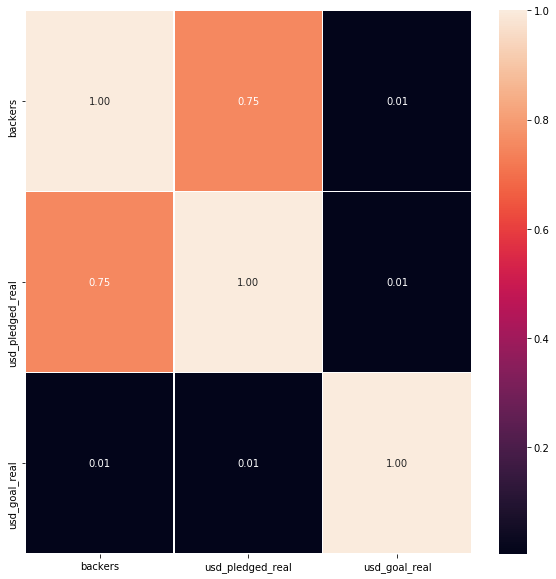

In [32]:
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(dataDF.corr(),annot=True,linewidths=.5,fmt=".2f",ax=ax)

## Feature Extraction

Create a list of dummy variablese for each categorical variable.

In [33]:
cat_columns = ["main_category", "currency", "state", "country"]
dummy_columns = {}

for col in cat_columns:
    dummies = pd.get_dummies(dataDF[col], prefix=col)
    dummy_columns[col] = dummies.columns.values
    dataDF = dataDF.merge(dummies, left_index=True, right_index=True)
    
dataDF.head()
dummy_columns

{'main_category': array(['main_category_Art', 'main_category_Comics',
        'main_category_Crafts', 'main_category_Dance',
        'main_category_Design', 'main_category_Fashion',
        'main_category_Film & Video', 'main_category_Food',
        'main_category_Games', 'main_category_Journalism',
        'main_category_Music', 'main_category_Photography',
        'main_category_Publishing', 'main_category_Technology',
        'main_category_Theater'], dtype=object),
 'currency': array(['currency_AUD', 'currency_CAD', 'currency_CHF', 'currency_DKK',
        'currency_EUR', 'currency_GBP', 'currency_HKD', 'currency_JPY',
        'currency_MXN', 'currency_NOK', 'currency_NZD', 'currency_SEK',
        'currency_SGD', 'currency_USD'], dtype=object),
 'state': array(['state_failed', 'state_successful'], dtype=object),
 'country': array(['country_AT', 'country_AU', 'country_BE', 'country_CA',
        'country_CH', 'country_DE', 'country_DK', 'country_ES',
        'country_FR', 'country_GB'

## Set up Experiment

Create training and testing set.

In [34]:

df_train, df_test = train_test_split(dataDF, stratify=dataDF["state"])
print(dataDF.shape, df_train.shape, df_test.shape)

(331675, 63) (248756, 63) (82919, 63)


Use a label encoder to create a training and testing set of just the states of the projects for the base model.

In [35]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train["state"].astype("str"))
y_test = encoder.transform(df_test["state"].astype("str"))
print(y_train[:25])

[0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1]


## Classification

### Simple Logistical Regression Model

Create a base model Simple Logical Regression model using the accuracy and confusion matrix metrics. Accuracy is the correctly classified samples divided by the total number of samples. A confusion matrix is used find why samples are predicted to be 'successful' or 'failed'. Only a diagonal in the matrix means that every prediction was correct.

In [36]:
print(df_train.shape)
zeros_train = np.zeros(df_train.shape)
zeros_test = np.zeros(df_test.shape)

base_lr = SGDClassifier(max_iter=100, loss="log")
base_lr.fit(zeros_train, y_train)
pred_base = base_lr.predict(zeros_test)
pred_probability = base_lr.predict_proba(zeros_test)

base_accuracy = accuracy_score(y_test, pred_base)
base_loss = log_loss(y_test,pred_probability)
cm = confusion_matrix(y_test, pred_base)

print("Base Accuracy:",base_accuracy)
print("Base Loss:", base_loss)
print("Base Labels:", encoder.classes_)
print("Base Confusion Matrix:\n", cm)

(248756, 63)


c:\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Base Accuracy: 0.5961239281708656
Base Loss: 0.674640476891898
Base Labels: ['failed' 'successful']
Base Confusion Matrix:
 [[49430     0]
 [33489     0]]


In [37]:
x_train = df_train[["usd_goal_real"]].astype("float64").values
x_test =df_test[["usd_goal_real"]].astype("float64").values

imputer = SimpleImputer()
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

simple_lr = SGDClassifier(max_iter=100, loss="log")
simple_lr.fit(x_train,y_train)
pred_state = simple_lr.predict(x_test)
pred_probability = simple_lr.predict_proba(x_test)

null_acc = accuracy_score(y_test,pred_state)
loss = log_loss(y_test, pred_probability)
cm = confusion_matrix(y_test, pred_state)

print("Goal Accuracy:",null_acc)
print("Goal Loss:",loss)
print("Goal Labels:",encoder.classes_)
print("Goal Confusion Matrix:\n",cm)

c:\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Goal Accuracy: 0.5961239281708656
Goal Loss: 0.65831743534016
Goal Labels: ['failed' 'successful']
Goal Confusion Matrix:
 [[49430     0]
 [33489     0]]


c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


### Greedy Algorithm Logistical Regression Model

A greedy algorithm will identify the variables that will improve the fit model. Those variables can be used to create the best model to predict the success of a project.

In [38]:
dataDF.columns[:25]

Index(['main_category', 'currency', 'deadline', 'launched', 'state', 'backers',
       'country', 'usd_pledged_real', 'usd_goal_real', 'main_category_Art',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'currency_AUD'],
      dtype='object')

In [39]:
num_cols = ["usd_goal_real"]
cat_cols = []

for d in dummy_columns["main_category"]:
    cat_cols.append(d)
for d in dummy_columns["currency"]:
    cat_cols.append(d)
for d in dummy_columns["country"]:
    cat_cols.append(d)
    
cand_cols = num_cols + cat_cols

In [40]:
def create_feature_matrices(df_train, df_test, selected_columns, dummy_columns):
    """
    Creates feature matrices for the training and testing sets from the given dataframes.
    The feature matrices are built from the columns given in selected columns.
    """
    
    # keep track of numerical features
    numerical_trial_columns = []
    
    # keep track of dummy features for categorical variables
    categorical_trial_columns = []
    
    # build feature lists
    for col_name in selected_columns:
        if col_name in dummy_columns:
            categorical_trial_columns.extend(dummy_columns[col_name])
        else:
            numerical_trial_columns.append(col_name)

    # transform numerical features
    if len(numerical_trial_columns) > 0:
        X_train_numerical = df_train[numerical_trial_columns].astype("float64").values
        X_test_numerical = df_test[numerical_trial_columns].astype("float64").values
    
        imputer = SimpleImputer()
        X_train_numerical = imputer.fit_transform(X_train_numerical)
        X_test_numerical = imputer.transform(X_test_numerical)
    
        scaler = StandardScaler()
        X_train_numerical = scaler.fit_transform(X_train_numerical)
        X_test_numerical = scaler.transform(X_test_numerical)
    
    # select categorical features
    if len(categorical_trial_columns) > 0:
        X_train_categorical = df_train[categorical_trial_columns].astype("float64").values
        X_test_categorical = df_test[categorical_trial_columns].astype("float64").values
    
    # concatenate feature matrices
    if len(numerical_trial_columns) > 0 and len(categorical_trial_columns) > 0:
        X_train = np.hstack([X_train_numerical, X_train_categorical])
        X_test = np.hstack([X_test_numerical, X_test_categorical])
    elif len(numerical_trial_columns) > 0:
        X_train = X_train_numerical
        X_test = X_test_numerical
    else:
        X_train = X_train_categorical
        X_test = X_test_categorical
        
    return X_train, X_test

In [41]:
print("Null Model Accuracy:", base_accuracy)

col_accuracies = []
for col in cand_cols:
    x_train, x_test = create_feature_matrices(df_train,
                                             df_test,
                                             [col],
                                             {})
    
    simple_lr = SGDClassifier(max_iter=10, tol=1e-3,loss="log")
    simple_lr.fit(x_train, y_train)
    pred_state = simple_lr.predict(x_test)
    pred_probability = simple_lr.predict_proba(x_test)
    accuracy = accuracy_score(y_test, pred_state)
    loss = log_loss(y_test, pred_probability)
    print() 
    print(col + " Accuracy:", accuracy)
    print(col + " Loss:", loss)
    col_accuracies.append((accuracy, col))
    
col_accuracies.sort(key=lambda p: p[0], reverse=True)
sorted_columns = [col for _, col in col_accuracies]
print()
print("Sorted columns:" + str(sorted_columns))

Null Model Accuracy: 0.5961239281708656


c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



usd_goal_real Accuracy: 0.5961239281708656
usd_goal_real Loss: 0.6601483279538276

main_category_Art Accuracy: 0.5961239281708656
main_category_Art Loss: 0.6748068553515075

main_category_Comics Accuracy: 0.6010082128342117
main_category_Comics Loss: 0.6734812196687288

main_category_Crafts Accuracy: 0.5961239281708656
main_category_Crafts Loss: 0.6735429315266703

main_category_Dance Accuracy: 0.5993439380600345
main_category_Dance Loss: 0.6745642787364475

main_category_Design Accuracy: 0.5961239281708656
main_category_Design Loss: 0.6746858806460893

main_category_Fashion Accuracy: 0.5961239281708656
main_category_Fashion Loss: 0.6729924624074026

main_category_Film & Video Accuracy: 0.5961239281708656
main_category_Film & Video Loss: 0.6744582075495479

main_category_Food Accuracy: 0.5961239281708656
main_category_Food Loss: 0.6734883685022282

main_category_Games Accuracy: 0.5961239281708656
main_category_Games Loss: 0.6747876074520908

main_category_Journalism Accuracy: 0.596123

In [42]:
base_model_columns = []
base_loss = loss
base_accuracy = null_acc

print("Base Model Accuracy:", base_accuracy)
print("Base Model Loss:", base_loss)
print()

for col_name in sorted_columns:
    # track all column names
    trial_columns = base_model_columns[:]
    trial_columns.append(col_name)

    X_train, X_test = create_feature_matrices(df_train,
                                             df_test,
                                             trial_columns,
                                             {})
    
    trial_lr = SGDClassifier(max_iter=50,tol=1e-3, loss="log", penalty="l2")
    trial_lr.fit(X_train, y_train)
    pred_labels = trial_lr.predict(X_test)
    pred_prob = trial_lr.predict_proba(X_test)
    trial_accuracy = accuracy_score(y_test, pred_labels)
    trial_loss = log_loss(y_test, pred_prob)
    print()
    print(str(trial_columns) + " Model Accuracy:", trial_accuracy)
    print(str(trial_columns) + " Model Loss:", trial_loss)

    if trial_accuracy > base_accuracy:
        print("Updating base model")
        base_loss = trial_loss
        base_model_columns = trial_columns
        base_accuracy = trial_accuracy
    print()
    print("Base Model Loss:", base_loss)
    print("Base Model Accuracy:", base_accuracy)
    print()
    
print("Our chosen columns are: " + str(base_model_columns))

Base Model Accuracy: 0.5961239281708656
Base Model Loss: 0.6745521414002689


['main_category_Theater'] Model Accuracy: 0.6038061240487704
['main_category_Theater'] Model Loss: 0.6714572337702323
Updating base model

Base Model Loss: 0.6714572337702323
Base Model Accuracy: 0.6038061240487704


['main_category_Theater', 'main_category_Music'] Model Accuracy: 0.6101858440164498
['main_category_Theater', 'main_category_Music'] Model Loss: 0.6664504619449657
Updating base model

Base Model Loss: 0.6664504619449657
Base Model Accuracy: 0.6101858440164498


['main_category_Theater', 'main_category_Music', 'main_category_Comics'] Model Accuracy: 0.6086904087121167
['main_category_Theater', 'main_category_Music', 'main_category_Comics'] Model Loss: 0.6637149543510993

Base Model Loss: 0.6664504619449657
Base Model Accuracy: 0.6101858440164498


['main_category_Theater', 'main_category_Music', 'main_category_Dance'] Model Accuracy: 0.6134058539056187
['main_category_Theater', 'main_category_Mus

c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real'] Model Accuracy: 0.6189172565998142
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real'] Model Loss: 0.652101772735644
Updating base model

Base Model Loss: 0.652101772735644
Base Model Accuracy: 0.6189172565998142



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Art'] Model Accuracy: 0.6187845970163653
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Art'] Model Loss: 0.6502682779414557

Base Model Loss: 0.652101772735644
Base Model Accuracy: 0.6189172565998142



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Crafts'] Model Accuracy: 0.616529384097734
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Crafts'] Model Loss: 0.650732115139134

Base Model Loss: 0.652101772735644
Base Model Accuracy: 0.6189172565998142



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Design'] Model Accuracy: 0.6077859115522377
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Design'] Model Loss: 0.6503722015100974

Base Model Loss: 0.652101772735644
Base Model Accuracy: 0.6189172565998142



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion'] Model Accuracy: 0.6204850516769377
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion'] Model Loss: 0.649583053718561
Updating base model

Base Model Loss: 0.649583053718561
Base Model Accuracy: 0.6204850516769377



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Film & Video'] Model Accuracy: 0.6199182334567469
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Film & Video'] Model Loss: 0.6483337112579667

Base Model Loss: 0.649583053718561
Base Model Accuracy: 0.6204850516769377



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Food'] Model Accuracy: 0.6173977013712177
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Food'] Model Loss: 0.6484197453010154

Base Model Loss: 0.649583053718561
Base Model Accuracy: 0.6204850516769377



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Games'] Model Accuracy: 0.6177233203487741
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Games'] Model Loss: 0.6511359319351403

Base Model Loss: 0.649583053718561
Base Model Accuracy: 0.6204850516769377



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism'] Model Accuracy: 0.6209915700864699
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism'] Model Loss: 0.6493106066003063
Updating base model

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'main_category_Photography'] Model Accuracy: 0.6153475078088255
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'main_category_Photography'] Model Loss: 0.6501217198788357

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'main_category_Publishing'] Model Accuracy: 0.6082683100375065
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'main_category_Publishing'] Model Loss: 0.6495177939059055

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699


['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'main_category_Technology'] Model Accuracy: 0.6180489393263305
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'main_category_Technology'] Model Loss: 0.6470048128870173

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_AUD'] Model Accuracy: 0.6201111928508545
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_AUD'] Model Loss: 0.648847789713659

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_CAD'] Model Accuracy: 0.6082321301511113
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_CAD'] Model Loss: 0.6493160168306035

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_CHF'] Model Accuracy: 0.6173977013712177
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_CHF'] Model Loss: 0.6485407976710171

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_DKK'] Model Accuracy: 0.6188448968270239
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_DKK'] Model Loss: 0.6498992849740455

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_EUR'] Model Accuracy: 0.6173494615226908
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_EUR'] Model Loss: 0.649592495859276

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_GBP'] Model Accuracy: 0.6200991328887228
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_GBP'] Model Loss: 0.6498166983975409

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_HKD'] Model Accuracy: 0.6190378562211315
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_HKD'] Model Loss: 0.6487533956599706

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_JPY'] Model Accuracy: 0.6172650417877688
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_JPY'] Model Loss: 0.6492400073078431

Base Model Loss: 0.6493106066003063
Base Model Accuracy: 0.6209915700864699



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN'] Model Accuracy: 0.6219081272084805
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN'] Model Loss: 0.6501305494290388
Updating base model

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_NOK'] Model Accuracy: 0.6169032429238173
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_NOK'] Model Loss: 0.6499396710840578

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_NZD'] Model Accuracy: 0.6077014918173157
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_NZD'] Model Loss: 0.649194782640524

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_SEK'] Model Accuracy: 0.618241898720438
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_SEK'] Model Loss: 0.648809941604954

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_SGD'] Model Accuracy: 0.6174821211061398
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_SGD'] Model Loss: 0.649490426732956

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_USD'] Model Accuracy: 0.6189172565998142
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'currency_USD'] Model Loss: 0.6492200355539152

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_AT'] Model Accuracy: 0.615841966256226
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_AT'] Model Loss: 0.6498947815764985

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_AU'] Model Accuracy: 0.6170479624693979
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_AU'] Model Loss: 0.6492275547420007

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_BE'] Model Accuracy: 0.6157334265970404
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_BE'] Model Loss: 0.6495697201647449

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_CA'] Model Accuracy: 0.6215945681930559
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_CA'] Model Loss: 0.649904927745216

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_CH'] Model Accuracy: 0.6074844124989448
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_CH'] Model Loss: 0.6509131038863187

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_DE'] Model Accuracy: 0.6169514827723441
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_DE'] Model Loss: 0.6496387949965347

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_DK'] Model Accuracy: 0.6169756026966076
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_DK'] Model Loss: 0.6490759219185149

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_ES'] Model Accuracy: 0.6208468505408893
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_ES'] Model Loss: 0.6496630140810347

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_FR'] Model Accuracy: 0.6211121697077872
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_FR'] Model Loss: 0.6496063323180812

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_GB'] Model Accuracy: 0.617168562090715
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_GB'] Model Loss: 0.6491403332436047

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_HK'] Model Accuracy: 0.6160711055367286
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_HK'] Model Loss: 0.6495909409969995

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_IE'] Model Accuracy: 0.6170117825830027
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_IE'] Model Loss: 0.6498472884704533

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_IT'] Model Accuracy: 0.6112471206840411
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_IT'] Model Loss: 0.6502813232181598

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_JP'] Model Accuracy: 0.6168670630374221
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_JP'] Model Loss: 0.6510242831717621

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_LU'] Model Accuracy: 0.6176750805002472
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_LU'] Model Loss: 0.6490213932106755

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_MX'] Model Accuracy: 0.6177956801215644
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_MX'] Model Loss: 0.6487172153292149

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_N,0"'] Model Accuracy: 0.6131405347387209
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_N,0"'] Model Loss: 0.6498802395843767

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_NL'] Model Accuracy: 0.6205212315633329
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_NL'] Model Loss: 0.6488620692800887

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_NO'] Model Accuracy: 0.6209795101243382
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_NO'] Model Loss: 0.6491009519838605

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_NZ'] Model Accuracy: 0.6173132816362956
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_NZ'] Model Loss: 0.6508757933789822

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_SE'] Model Accuracy: 0.6176750805002472
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_SE'] Model Loss: 0.6489952547944082

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_SG'] Model Accuracy: 0.6202920922828302
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_SG'] Model Loss: 0.6490485560289503

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805


['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_US'] Model Accuracy: 0.6191222759560535
['main_category_Theater', 'main_category_Music', 'main_category_Dance', 'usd_goal_real', 'main_category_Fashion', 'main_category_Journalism', 'currency_MXN', 'country_US'] Model Loss: 0.6493325326366712

Base Model Loss: 0.6501305494290388
Base Model Accuracy: 0.6219081272084805

Our chosen columns are

c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [43]:
X_train, X_test = create_feature_matrices(df_train,
                                          df_test,
                                          base_model_columns,
                                          {})
    
lr_greedy = SGDClassifier(max_iter=100, loss="log")
lr_greedy.fit(X_train, y_train)
pred_state_greedy = lr_greedy.predict(X_test)
trial_accuracy = accuracy_score(y_test, pred_state_greedy)
cm = confusion_matrix(y_test, pred_state_greedy)
print()
print("Greedy Model Accuracy:", trial_accuracy)
print("Greedy Labels:", encoder.classes_)
print("Greedy Confusion matrix:")
print(cm)

c:\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)



Greedy Model Accuracy: 0.6173253415984273
Greedy Labels: ['failed' 'successful']
Greedy Confusion matrix:
[[43134  6296]
 [25435  8054]]


c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Text(0, 0.5, 'True Positive Rate')

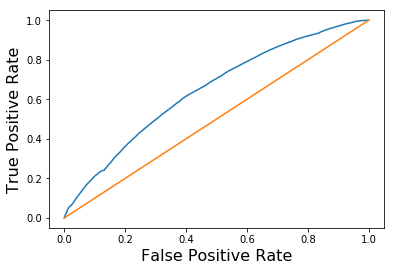

In [44]:
from sklearn.metrics import roc_curve

pred_proba = lr_greedy.predict_proba(X_test)

# turn multiclass problem into binary problem
pred_proba_1 = 1.0 - pred_proba[:, 0]
y_test_1 = [0 if y == 0 else 1 for y in y_test]

fpr, tpr, _ = roc_curve(y_test_1, pred_proba_1)

plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)

In the hypothesis it was believed that the projects goal and its main category would be the best variables to predict whether a project would be successful or not. That hypothesis was correct in that the goal and the main category were the best predictors. They were the only two variable selected by the greedy algorithm for the model.
The accuracy of the fit is 62.97%. While this is not an amazing result, it is > than 